In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# !pip install -q kaggle
# !mkdir -p /root/.kaggle

# !cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' /root/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

# !kaggle datasets download -d suyashdamle/cyclegan

# !unzip -q cyclegan.zip horse2zebra/horse2zebra/*
# !unzip -q cyclegan.zip iphone2dslr_flower/iphone2dslr_flower/*
# !unzip -q cyclegan.zip vangogh2photo/vangogh2photo/*

Mounted at /content/drive
100% 3.40G/3.40G [03:08<00:00, 24.2MB/s]
100% 3.40G/3.40G [03:08<00:00, 19.3MB/s]


In [2]:
import os
import torch
import torch.nn as nn

In [3]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, stride, 1, bias=True, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(2e-1),
        )
        
    def forward(self, x):
        return self.conv(x)
    
# each value in 30x30 output sees a 70x70 patch
class Discriminator(nn.Module):
    def __init__(self, in_channels, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode='reflect',
            ),
            nn.LeakyReLU(2e-1, inplace=True),
        )
        
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(Block(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature
        layers.append(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode='reflect'))
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        x = torch.sigmoid(x)
        return x

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs)
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity(),
        )
        
    def forward(self, x):
        return self.conv(x)
    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1, stride=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1, stride=1),
        )
        
    def forward(self, x):
        return x + self.block(x)

# The main difference between Sequential is that ModuleList have not a forward method so the inner layers are not connected.
# the model layer stored in the ModuleList still has to be actively used in the forward() block, unlike Sequential that can be directly input.
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9): # residual is 9 if img_size=256x256, 6 if img_size=128x128
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode='reflect'),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        
        self.down_blocks = nn.ModuleList(
            [
                ConvBlock(num_features, num_features*2, down=True, kernel_size=3, stride=2, padding=1),
                ConvBlock(num_features*2, num_features*4, down=True, kernel_size=3, stride=2, padding=1),
            ]
        )
        
        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(num_features*4) for _ in range(num_residuals)]
        )
        
        self.up_blocks = nn.ModuleList(
            [
                ConvBlock(num_features*4, num_features*2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
                ConvBlock(num_features*2, num_features*1, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
            ]
        )
        
        self.last = nn.Conv2d(num_features*1, img_channels, kernel_size=7, stride=1, padding=3, padding_mode='reflect')
        
    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.residual_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        x = self.last(x)
        x = torch.tanh(x)
        return x

In [5]:
RANDOM_SEED = 42

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# clear the GPUs
torch.cuda.empty_cache()

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 1e-5
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()
LAMBDA_IDENTITY = 0.5
LAMBDA_CYCLE = 10
HEIGHT = 256
WIDTH = 256
CHANNELS_IMG = 3
NUM_EPOCHS = 2

import shutil

# cleaning previous images
if os.path.exists('saved_images'):
    shutil.rmtree('saved_images', ignore_errors=True)

In [6]:
from PIL import Image
import numpy as np

import torch
from torch.utils.data import Dataset

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm.auto import tqdm

from torchvision.utils import make_grid, save_image

In [7]:
transforms = A.Compose(
    [
        A.Resize(width=WIDTH, height=HEIGHT),
#         A.HorizontalFlip(p=0.5),
#         A.VerticalFlip(p=0.5),
        A.Normalize(mean=[5e-1, 5e-1, 5e-1], std=[5e-1, 5e-1, 5e-1], max_pixel_value=255.0),
        ToTensorV2(),
    ],
    additional_targets={'image0': 'image'},
)

In [8]:
class ABDataset(Dataset):
    def __init__(self, root_a, root_b, transform=None):
        self.root_a = root_a
        self.root_b = root_b
        self.transform = transform

        self.a_images = os.listdir(root_a)
        self.b_images = os.listdir(root_b)
        self.length_dataset = max(len(self.a_images), len(self.b_images))
        self.a_len = len(self.a_images)
        self.b_len = len(self.b_images)

    def __len__(self):
        return self.length_dataset

    def __getitem__(self, index):
        a_img = self.a_images[index % self.a_len]
        b_img = self.b_images[index % self.b_len]

        a_path = os.path.join(self.root_a, a_img)
        b_path = os.path.join(self.root_b, b_img)

        a_img = np.array(Image.open(a_path).convert("RGB"))
        b_img = np.array(Image.open(b_path).convert("RGB"))

        if self.transform:
            augmentations = self.transform(image=a_img, image0=b_img)
            a_img = augmentations["image"]
            b_img = augmentations["image0"]

        return a_img, b_img

In [9]:
# horse2Zerbra
train_dataset = ABDataset(root_a='horse2zebra/horse2zebra/trainA', root_b='horse2zebra/horse2zebra/trainB', transform=transforms)
val_dataset = ABDataset(root_a='horse2zebra/horse2zebra/testA', root_b='horse2zebra/horse2zebra/testB', transform=transforms)

In [10]:
# # iphone2dslr
# train_dataset = ABDataset(root_a='iphone2dslr_flower/iphone2dslr_flower/trainA', root_b='iphone2dslr_flower/iphone2dslr_flower/trainB', transform=transforms)
# val_dataset = ABDataset(root_a='iphone2dslr_flower/iphone2dslr_flower/testA', root_b='iphone2dslr_flower/iphone2dslr_flower/testB', transform=transforms)

In [11]:
# # Vangogh2photo
# train_dataset = ABDataset(root_a='vangogh2photo/vangogh2photo/trainA', root_b='vangogh2photo/vangogh2photo/trainB', transform=transforms)
# val_dataset = ABDataset(root_a='vangogh2photo/vangogh2photo/testA', root_b='vangogh2photo/vangogh2photo/testB', transform=transforms)

(-0.5, 1291.5, 259.5, -0.5)

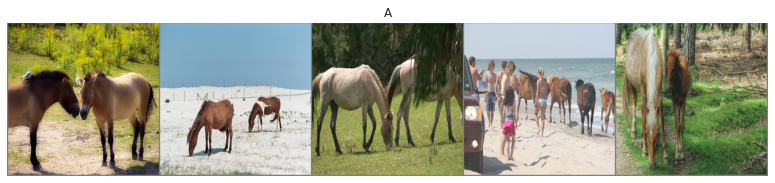

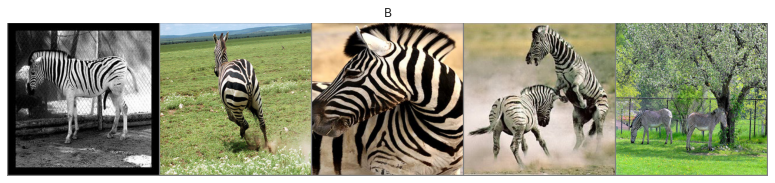

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline
sns.set()

# Get the first 10 training examples and their labels
a_arr, b_arr = zip(*[train_dataset[i] for i in range(5)])

# Convert the images to a tensor
a = torch.stack(a_arr)
b = torch.stack(b_arr)

# Use make_grid to create a grid of images
grid_a = make_grid(a, nrow=5, ) * 0.5 + 0.5
grid_b = make_grid(b, nrow=5, ) * 0.5 + 0.5

# Convert the grid to a NumPy array and plot it
fig, ax = plt.subplots(figsize=(30, 30))
plt.subplot(1, 2, 1)
plt.imshow(grid_a.numpy().transpose((1, 2, 0)))
plt.title("A")
plt.axis('off')

# plt.figure() # calling figure to create new figure
fig, ax = plt.subplots(figsize=(30, 10))
plt.subplot(1, 2, 2)
plt.imshow(grid_b.numpy().transpose((1, 2, 0)))
plt.title("B")
plt.axis('off')

In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, drop_last=False)

In [14]:
disc_A = Discriminator(in_channels=3).to(DEVICE)
disc_B = Discriminator(in_channels=3).to(DEVICE)

gen_A = Generator(img_channels=3, num_residuals=9).to(DEVICE)
gen_B = Generator(img_channels=3, num_residuals=9).to(DEVICE)

opt_disc = optim.Adam(
    list(disc_A.parameters()) + list(disc_B.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

opt_gen = optim.Adam(
    list(gen_A.parameters()) + list(gen_B.parameters()),
    lr=LEARNING_RATE,
    betas=(0.5, 0.999),
)

L1 = nn.L1Loss() # for cycle consistency and identity loss
mse = nn.MSELoss() # for adveserial loss

g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()

In [15]:
%%timeit -r 1 -n 1
for epoch in tqdm(range(1, NUM_EPOCHS + 1), leave=True, desc='Epoch: '):
    progress = tqdm(train_loader, leave=False, total=len(train_loader), desc='Batch: ')
    for idx, (a, b) in enumerate(progress):
        a, b = a.to(DEVICE), b.to(DEVICE)

        # discriminator
        with torch.cuda.amp.autocast():
            # a
            fake_a = gen_A(b)
            disc_a_real = disc_A(a)
            disc_a_fake = disc_A(fake_a.detach())
            
            disc_a_real_loss = mse(disc_a_real, torch.ones_like(disc_a_real))
            disc_a_fake_loss = mse(disc_a_fake, torch.zeros_like(disc_a_fake))
            disc_a_loss = disc_a_real_loss + disc_a_fake_loss
            
            # b
            fake_b = gen_B(a)
            disc_b_real = disc_B(b)
            disc_b_fake = disc_B(fake_b.detach())
            
            disc_b_real_loss = mse(disc_b_real, torch.ones_like(disc_b_real))
            disc_b_fake_loss = mse(disc_b_fake, torch.zeros_like(disc_b_fake))
            disc_b_loss = disc_b_real_loss + disc_b_fake_loss
            
            disc_loss = (disc_a_loss + disc_b_loss) / 2
        
        opt_disc.zero_grad() # can call model.zero_grad(), which is faster, but have to do for all the models individually
        d_scaler.scale(disc_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()
        
        # generator
        with torch.cuda.amp.autocast():
            # adversarial loss for both generators
            disc_a_fake = disc_A(fake_a)
            disc_b_fake = disc_B(fake_b)

            # we want to fool the discriminator, so we do torch.ones_like for fake data
            loss_gen_a = mse(disc_a_fake, torch.ones_like(disc_a_fake))
            loss_gen_b = mse(disc_b_fake, torch.ones_like(disc_b_fake))

            # cycle loss
            cycle_a = gen_A(fake_b)
            cycle_b = gen_B(fake_a)
            cycle_a_loss = L1(a, cycle_a)
            cycle_b_loss = L1(b, cycle_b)

            # identity loss (remove these for efficiency if you set lambda_identity=0)
            identity_a = gen_A(a)
            identity_b = gen_B(b)
            identity_a_loss = L1(a, identity_a)
            identity_b_loss = L1(b, identity_b)

            # add all together
            gen_loss = (
                loss_gen_a
                + loss_gen_b
                + cycle_a_loss * LAMBDA_CYCLE
                + cycle_b_loss * LAMBDA_CYCLE
                + identity_a_loss * LAMBDA_IDENTITY
                + identity_b_loss * LAMBDA_IDENTITY
            )
        
        opt_gen.zero_grad()
        g_scaler.scale(gen_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        if not (idx % 400):
            if not os.path.exists(f'saved_images/epoch_{epoch}'):
                os.makedirs(f'saved_images/epoch_{epoch}')

            fake_a_grid = make_grid([a.squeeze(), fake_b.squeeze()*0.5+0.5], nrow=2, normalize=True)
            fake_b_grid = make_grid([b.squeeze(), fake_a.squeeze()*0.5+0.5], nrow=2, normalize=True)

            save_image(fake_a_grid, f'saved_images/epoch_{epoch}/a_{idx}.png')
            save_image(fake_b_grid, f'saved_images/epoch_{epoch}/b_{idx}.png')

    if not (epoch % int(NUM_EPOCHS * 0.1)):
        print(f'Epoch: [{epoch}/{NUM_EPOCHS}] | LossD: {disc_loss:.4f} | LossG: {gen_loss:.4f}')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Batch:   0%|          | 0/1334 [00:00<?, ?it/s]

Batch:   0%|          | 0/1334 [00:00<?, ?it/s]

11min 33s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


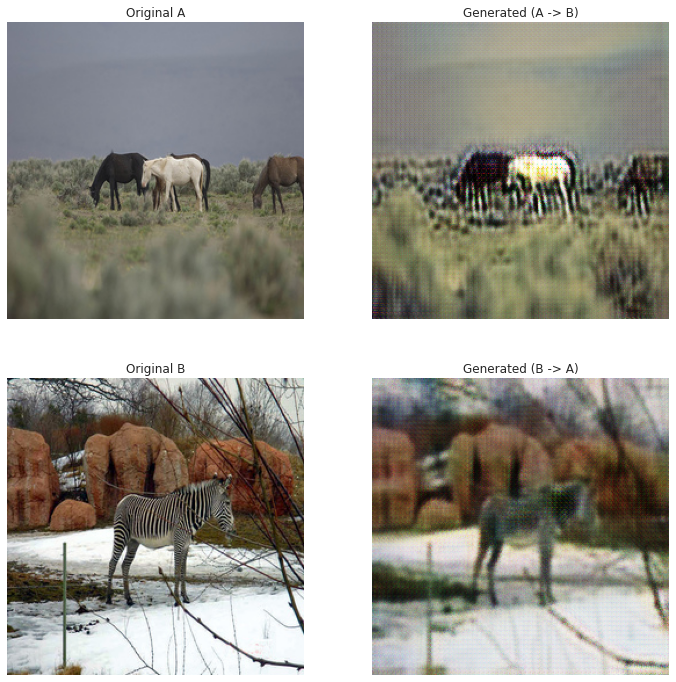

In [16]:
import torchvision.transforms as transforms

fig, ax = plt.subplots(figsize=(12, 12))

# val_iter = iter(val_loader)
# a_arr, b_arr = next(val_iter)

# rand_im = torch.randint(low=0, high=BATCH_SIZE, size=(1,)).item()
# a, b = a_arr[rand_im] * 0.5 + 0.5, b_arr[rand_im] * 0.5 + 0.5

rand_im = torch.randint(len(train_dataset), size=(1,)).item()
a, b = train_dataset[rand_im]

a_orgi, b_orgi = a * 0.5 + 0.5, b * 0.5 + 0.5

plt.subplot(2, 2, 1)
plt.axis('off')
plt.title("Original A")
plt.imshow(a_orgi.numpy().transpose(1, 2, 0))
# plt.imshow(transforms.ToPILImage()(a))

plt.subplot(2, 2, 3)
plt.axis('off')
plt.title("Original B")
plt.imshow(b_orgi.numpy().transpose(1, 2, 0))
# plt.imshow(transforms.ToPILImage()(b))

# Generated
with torch.inference_mode():
    a = a.to(DEVICE)
    b = b.to(DEVICE)

    gen_b = gen_B(a).squeeze() * 0.5 + 0.5 
    plt.subplot(2, 2, 2)
    plt.axis('off')
    plt.title("Generated (A -> B)")
    plt.imshow(gen_b.cpu().detach().numpy().transpose(1, 2, 0))
    # plt.imshow(transforms.ToPILImage()(gen_b))

    gen_a = gen_A(b).squeeze() * 0.5 + 0.5
    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.title("Generated (B -> A)")
    plt.imshow(gen_a.cpu().detach().numpy().transpose(1, 2, 0))
    # plt.imshow(transforms.ToPILImage()(gen_a))